In [40]:
#O time de Experiência precisa que você faça uma análise exploratória completa com os dados a sua disposição:
#  1. Entenda os gargalos
#  2. Crie os acompanhamentos e indicadores,
#  3. Gere insights, formule hipóteses 
# 4. Proponha um plano de ação.
# 
# Entregáveis esperados: análise quantitativa + data storytelling

In [41]:
import pandas as pd
from pathlib import Path
from IPython.display import display
import matplotlib.pyplot as plt


In [42]:
def load_cx_data(base_path: str | Path | None = None):
    """
    Load CX project datasets used in EDA.

    Parameters
    ----------
    base_path : str | Path | None
        Optional override for the directory containing the CSV files.

    Returns
    -------
    df_de_para : pd.DataFrame
        De-para tag hierarchy table.
    df_issues : pd.DataFrame
        Customer service issues dataset.
    """
    data_files = {
        "df_de_para": "de_para_tag_hierarquia.csv",
        "df_issues": "issues_atendimento_.csv",
    }

    candidate_dirs: list[Path] = []
    if base_path is not None:
        candidate_dirs.append(Path(base_path))

    cwd = Path.cwd()
    candidate_dirs.extend(
        [
            cwd / "data",
            cwd / "cx_project" / "data",
            cwd.parent / "data",
            cwd.parent / "cx_project" / "data",
        ]
    )
    if "__file__" in globals():
        candidate_dirs.append(Path(__file__).resolve().parent / ".." / "data")

    data_dir = None
    for candidate in candidate_dirs:
        if candidate is None:
            continue
        if all((candidate / fname).exists() for fname in data_files.values()):
            data_dir = candidate
            break

    if data_dir is None:
        searched = "; ".join(str(path.resolve()) for path in candidate_dirs if path is not None)
        raise FileNotFoundError(
            "Could not locate data directory. Checked: {searched}".format(searched=searched)
        )

    df_de_para = pd.read_csv(data_dir / data_files["df_de_para"])
    df_issues = pd.read_csv(data_dir / data_files["df_issues"])

    return df_de_para, df_issues


In [43]:
def clean_cx_data(df_de_para: pd.DataFrame, df_issues: pd.DataFrame):
    """Clean and standardize CX datasets used in the EDA.

    Parameters
    ----------
    df_de_para : pd.DataFrame
        Raw hierarchy mapping table.
    df_issues : pd.DataFrame
        Raw CX issues table.

    Returns
    -------
    tuple[pd.DataFrame, pd.DataFrame]
        Clean de-para and issues dataframes ready for analysis.
    """
    de_para = df_de_para.copy()
    text_cols = de_para.select_dtypes(include="object").columns
    for column in text_cols:
        de_para[column] = de_para[column].str.strip()
    de_para["tag_normalized"] = de_para["tag"].str.lower()
    de_para = de_para.drop_duplicates(subset="tag_normalized", keep="first")

    issues = df_issues.copy()
    issues["dt_data"] = pd.to_datetime(issues["dt_data"], errors="coerce", utc=True)
    issues = issues.dropna(subset=["dt_data"]).sort_values("dt_data")
    dt_no_tz = issues["dt_data"].dt.tz_localize(None)
    issues["dt_date"] = dt_no_tz.dt.date
    issues["dt_week"] = dt_no_tz.dt.to_period("W").astype(str)
    issues["dt_month"] = dt_no_tz.dt.to_period("M").astype(str)

    issues["id_cliente"] = (
        issues["id_cliente"].astype("string").str.strip().str.upper().replace({"": pd.NA})
    )
    issues["id_cliente"] = issues["id_cliente"].fillna("UNKNOWN_CLIENT")
    issues["canal"] = issues["canal"].astype("string").str.strip().str.title()
    issues["tag_normalized"] = issues["tag"].astype("string").str.strip().str.lower()

    issues = issues.drop_duplicates(subset=["id_issue"], keep="first")
    issues = issues.merge(
        de_para[["tag_normalized", "ds_hierarquia_a", "ds_hierarquia_b"]],
        on="tag_normalized",
        how="left",
        validate="m:1",
    )

    return de_para, issues


In [44]:
df_de_para_raw, df_issues_raw = load_cx_data()
print(f'Loaded raw de-para shape: {df_de_para_raw.shape}')
print(f'Loaded raw issues shape: {df_issues_raw.shape}')

df_de_para, df_issues = clean_cx_data(df_de_para_raw, df_issues_raw)
print(f'Cleaned de-para shape: {df_de_para.shape}')
print(f'Cleaned issues shape: {df_issues.shape}')


Loaded raw de-para shape: (481, 3)
Loaded raw issues shape: (107306, 5)
Cleaned de-para shape: (481, 4)
Cleaned issues shape: (79431, 11)


In [45]:
df_issues.head()

,dt_data,id_cliente,id_issue,canal,tag,dt_date,dt_week,dt_month,tag_normalized,ds_hierarquia_a,ds_hierarquia_b
0,2024-10-01 00:12:33+00:00,98EDC188-2F40-425A-904A-080ADB10F4A9-765GH,7920130,Chat,w3 - duvida - antecipacao fatura,2024-10-01,2024-09-30/2024-10-06,2024-10,w3 - duvida - antecipacao fatura,Cartão,Antecipação de Fatura
1,2024-10-01 00:21:09+00:00,5C4C6DCB-DEF0-4E86-85D6-16D907ED4403-765GH,7920179,Chat,w3 - duvida - valor total da fatura,2024-10-01,2024-09-30/2024-10-06,2024-10,w3 - duvida - valor total da fatura,Cartão,Não entendimento fatura
2,2024-10-01 00:36:22+00:00,07204021-27A5-447C-B248-CB964E424D0C-765GH,7920259,Chat,w3 - duvida - cadastramento de cartao google pay,2024-10-01,2024-09-30/2024-10-06,2024-10,w3 - duvida - cadastramento de cartao google pay,Cartão,Wallet
3,2024-10-01 00:39:11+00:00,D674B19B-1EF3-46C4-A91F-ECB3F1F6A5C1-765GH,7920272,Chat,wb-ras,2024-10-01,2024-09-30/2024-10-06,2024-10,wb-ras,Cartão,Rastreio de cartão
4,2024-10-01 00:39:50+00:00,10E3A8A9-512A-4F47-BC6A-56C46F586F94-765GH,7920278,Chat,w3 - duvida - cartao virtual,2024-10-01,2024-09-30/2024-10-06,2024-10,w3 - duvida - cartao virtual,Cartão,Cartão


In [46]:
df_de_para.head()

,tag,ds_hierarquia_a,ds_hierarquia_b,tag_normalized
0,w3 - solicitacao - 2 via cartao fraudado,Cartão,Segunda via cartão,w3 - solicitacao - 2 via cartao fraudado
1,wb-cdu,Cartão,Lançamentos duplicados,wb-cdu
2,w3 - solicitacao - cancelar insatisfacao,Cartão,Cancelamento de conta,w3 - solicitacao - cancelar insatisfacao
3,w3 - duvida - cancelamento de compra,Cartão,Cancelamento de compra no crédito,w3 - duvida - cancelamento de compra
4,wb-cf,Cartão,Compensação fatura,wb-cf


In [47]:
print('Issues with UNKNOWN_CLIENT id:', (df_issues['id_cliente'] == 'UNKNOWN_CLIENT').sum())
print('Issues without hierarchy mapping:', df_issues['ds_hierarquia_a'].isna().sum())
print('Tag coverage:', 1 - df_issues['ds_hierarquia_a'].isna().mean())
df_issues[df_issues['ds_hierarquia_a'].isna()][['tag']].drop_duplicates().head()


Issues with UNKNOWN_CLIENT id: 1
Issues without hierarchy mapping: 0
Tag coverage: 1.0


,tag


In [48]:
from textwrap import dedent


def describe_issues(df: pd.DataFrame):
    summary = {
        'row_count': len(df),
        'client_count': df['id_cliente'].nunique(),
        'channels': df['canal'].nunique(),
        'tags': df['tag'].nunique(),
        'date_min': df['dt_data'].min(),
        'date_max': df['dt_data'].max(),
    }
    print('Issues overview:')
    for k, v in summary.items():
        print(f'  {k}: {v}')
    print('\nMissing values:')
    print(df.isna().sum())


describe_issues(df_issues)


Issues overview:
  row_count: 79431
  client_count: 73534
  channels: 1
  tags: 420
  date_min: 2024-10-01 00:12:33+00:00
  date_max: 2024-12-31 23:46:09+00:00

Missing values:
dt_data            0
id_cliente         0
id_issue           0
canal              0
tag                0
dt_date            0
dt_week            0
dt_month           0
tag_normalized     0
ds_hierarquia_a    0
ds_hierarquia_b    0
dtype: int64


In [49]:
issues_daily = (
    df_issues.groupby('dt_date').agg(ticket_volume=('id_issue', 'count')).reset_index().sort_values('dt_date')
)
issues_monthly = (
    df_issues.groupby('dt_month').agg(ticket_volume=('id_issue', 'count')).reset_index().sort_values('dt_month')
)
print('Daily volume (last 10 days):')
display(issues_daily.tail(10))
print('\\nMonthly volume (last 6 months):')
display(issues_monthly.tail(6))


Daily volume (last 10 days):


,dt_date,ticket_volume
82,2024-12-22,426
83,2024-12-23,800
84,2024-12-24,434
85,2024-12-25,307
86,2024-12-26,798
87,2024-12-27,752
88,2024-12-28,561
89,2024-12-29,461
90,2024-12-30,748
91,2024-12-31,768


\nMonthly volume (last 6 months):


,dt_month,ticket_volume
0,2024-10,27905
1,2024-11,25984
2,2024-12,25542


In [50]:
channel_mix = (
    df_issues.groupby('canal').agg(ticket_volume=('id_issue','count')).sort_values('ticket_volume', ascending=False)
)
channel_mix['share'] = (channel_mix['ticket_volume'] / channel_mix['ticket_volume'].sum()).round(3)
print('Channel mix:')
display(channel_mix)

hierarchy_a = (
    df_issues.groupby('ds_hierarquia_a').agg(ticket_volume=('id_issue','count')).
    sort_values('ticket_volume', ascending=False).head(10)
)
print('\\nTop 10 hierarchy A topics:')
display(hierarchy_a)

top_tags = (
    df_issues.groupby('tag').agg(ticket_volume=('id_issue','count')).
    sort_values('ticket_volume', ascending=False).head(10)
)
print('\\nTop 10 tags:')
display(top_tags)


Channel mix:


,ticket_volume,share
canal,,
Chat,79431,1.0


\nTop 10 hierarchy A topics:


,ticket_volume
ds_hierarquia_a,
Cartão,58567
Fraude,11122
Conta,8834
Empréstimos,908


\nTop 10 tags:


,ticket_volume
tag,
w3 - duvida - estorno,3443
w3 - problema - nao reconhece compra online,2541
w3 - duvida - detalhamento de faturas,2142
w3 - solicitacao - cancelar limite baixo,1830
w3 - duvida - nao elegivel pix credito,1764
w3 - solicitacao - cancelar motivos pessoais,1613
w3 - solicitacao - resultado analise de contestacao,1565
w3 - duvida - antecipacao fatura,1492
w3 - reclamacao - desconhece recebimento,1397


In [51]:
key_points = []
peak_month = issues_monthly.sort_values('ticket_volume', ascending=False).iloc[0]
key_points.append(f"Maior volume mensal em {peak_month['dt_month']} com {int(peak_month['ticket_volume']):,} chamados.")
top_channel = channel_mix.iloc[0]
key_points.append(f"Canal líder: {top_channel.name} com {int(top_channel['ticket_volume']):,} tickets ({top_channel['share']*100:.1f}% share).")
top_topic = hierarchy_a.iloc[0]
key_points.append(f"Tema principal (hierarquia A): {top_topic.name} com {int(top_topic['ticket_volume']):,} tickets.")
print('Principais achados df_issues:')
for bullet in key_points:
    print(f"- {bullet}")


Principais achados df_issues:
- Maior volume mensal em 2024-10 com 27,905 chamados.
- Canal líder: Chat com 79,431 tickets (100.0% share).
- Tema principal (hierarquia A): Cartão com 58,567 tickets.


In [52]:
hierarchy_ab = (
    df_issues.groupby(['ds_hierarquia_a', 'ds_hierarquia_b'])
    .agg(ticket_volume=('id_issue', 'count'))
    .reset_index()
)
hierarchy_ab['share_within_a'] = (
    hierarchy_ab.groupby('ds_hierarquia_a')['ticket_volume']
    .transform(lambda x: x / x.sum())
).round(3)
print('Top hierarchy B themes within each hierarchy A:')
top_b_by_a = (
    hierarchy_ab.sort_values('ticket_volume', ascending=False)
    .groupby('ds_hierarquia_a')
    .head(5)
)
display(top_b_by_a)
print('\\nPares hierarquia A/B mais incidentes:')
display(hierarchy_ab.sort_values('ticket_volume', ascending=False).head(15))


Top hierarchy B themes within each hierarchy A:


,ds_hierarquia_a,ds_hierarquia_b,ticket_volume,share_within_a
6,Cartão,Cancelamento de conta,7322,0.125
98,Fraude,Não reconhecimento de compra no crédito,5260,0.473
5,Cartão,Cancelamento de compra no crédito,4990,0.085
8,Cartão,Compensação fatura,4840,0.083
20,Cartão,Informações sobre fatura,4329,0.074
35,Cartão,Segunda via cartão,3833,0.065
57,Conta,Envio de PIX,2006,0.227
101,Fraude,Resultado análise de fraude,1943,0.175
61,Conta,Gestão de Extrato,1392,0.158
89,Fraude,Alteração de Cadastro,1059,0.095


\nPares hierarquia A/B mais incidentes:


,ds_hierarquia_a,ds_hierarquia_b,ticket_volume,share_within_a
6,Cartão,Cancelamento de conta,7322,0.125
98,Fraude,Não reconhecimento de compra no crédito,5260,0.473
5,Cartão,Cancelamento de compra no crédito,4990,0.085
8,Cartão,Compensação fatura,4840,0.083
20,Cartão,Informações sobre fatura,4329,0.074
35,Cartão,Segunda via cartão,3833,0.065
32,Cartão,Recusa de compra,2750,0.047
10,Cartão,Desbloqueio de cartão,2652,0.045
37,Cartão,Todos os itens de pix no crédito,2550,0.044
13,Cartão,Dúvidas sobre pagamento de fatura,2437,0.042


In [53]:
issues_daily_metrics = issues_daily.copy()
issues_daily_metrics['rolling_7d'] = issues_daily_metrics['ticket_volume'].rolling(window=7, min_periods=1).mean()
issues_daily_metrics['wow_change_pct'] = (
    issues_daily_metrics['ticket_volume'].pct_change(periods=7).fillna(0) * 100
)
print('Daily volume with rolling 7-day average and WoW deltas (tail):')
display(issues_daily_metrics.tail(14))
print('\nLatest day vs 7-day avg:')
latest = issues_daily_metrics.iloc[-1]
print(f"  Date: {latest['dt_date']} | Tickets: {latest['ticket_volume']:,} | 7d avg: {latest['rolling_7d']:.1f} | WoW%: {latest['wow_change_pct']:.1f}%")


Daily volume with rolling 7-day average and WoW deltas (tail):


,dt_date,ticket_volume,rolling_7d,wow_change_pct
78,2024-12-18,875,795.571429,-12.060302
79,2024-12-19,1524,874.000000,56.307692
80,2024-12-20,1058,917.142857,39.947090
81,2024-12-21,736,916.000000,-1.075269
82,2024-12-22,426,919.714286,6.500000
83,2024-12-23,800,895.142857,-17.695473
84,2024-12-24,434,836.142857,-48.760331
85,2024-12-25,307,755.000000,-64.914286
86,2024-12-26,798,651.285714,-47.637795
87,2024-12-27,752,607.571429,-28.922495



Latest day vs 7-day avg:
  Date: 2024-12-31 | Tickets: 768 | 7d avg: 627.9 | WoW%: 77.0%


In [54]:
client_volume = (
    df_issues.groupby('id_cliente')
    .agg(ticket_volume=('id_issue', 'count'))
    .sort_values('ticket_volume', ascending=False)
)
client_volume['share'] = client_volume['ticket_volume'] / client_volume['ticket_volume'].sum()
client_volume['cum_share'] = client_volume['share'].cumsum()
print('Top 10 clients by ticket volume:')
display(client_volume.head(10))
print('\nClient concentration:')
for pct in (0.01, 0.05, 0.10):
    cutoff = int(len(client_volume) * pct)
    cutoff = max(cutoff, 1)
    share = client_volume.head(cutoff)['share'].sum()
    print(f"  Top {pct:.0%} clients (~{cutoff}) generate {share*100:.1f}% of tickets")


Top 10 clients by ticket volume:


,ticket_volume,share,cum_share
id_cliente,,,
64B4E2F7-8396-4562-A55D-21C3F07299B8-765GH,8,0.000101,0.000101
0192268A-EB69-73E0-91AD-D41132518C36-765GH,7,0.000088,0.000189
C41B4C2E-33EE-4A68-84A0-4D408B928AA4-765GH,6,0.000076,0.000264
43E5066E-AC30-4FFC-86FF-1B3AA48C9581-765GH,6,0.000076,0.000340
0192D3BF-67E4-7701-9FC8-AF536D311C41-765GH,6,0.000076,0.000415
17549449-C410-43D8-BA0D-1FD70D355BC3-765GH,5,0.000063,0.000478
3B5A78E7-9CE8-40C5-9294-5158604010C6-765GH,5,0.000063,0.000541
4D6D5E6B-C3EC-4F78-AE17-152437568BFE-765GH,5,0.000063,0.000604
011BAD0F-734C-44AF-92F6-22D4355B31B3-765GH,5,0.000063,0.000667



Client concentration:
  Top 1% clients (~735) generate 2.8% of tickets
  Top 5% clients (~3676) generate 10.2% of tickets
  Top 10% clients (~7353) generate 16.7% of tickets


In [55]:
issues_daily_metrics = issues_daily.copy()
issues_daily_metrics['rolling_7d'] = issues_daily_metrics['ticket_volume'].rolling(window=7, min_periods=1).mean()
issues_daily_metrics['wow_change_pct'] = (
    issues_daily_metrics['ticket_volume'].pct_change(periods=7).fillna(0) * 100
)
print('Daily volume with rolling 7-day average and WoW deltas (tail):')
display(issues_daily_metrics.tail(14))
print('\nLatest day vs 7-day avg:')
latest = issues_daily_metrics.iloc[-1]
print(f"  Date: {latest['dt_date']} | Tickets: {latest['ticket_volume']:,} | 7d avg: {latest['rolling_7d']:.1f} | WoW%: {latest['wow_change_pct']:.1f}%")


Daily volume with rolling 7-day average and WoW deltas (tail):


,dt_date,ticket_volume,rolling_7d,wow_change_pct
78,2024-12-18,875,795.571429,-12.060302
79,2024-12-19,1524,874.000000,56.307692
80,2024-12-20,1058,917.142857,39.947090
81,2024-12-21,736,916.000000,-1.075269
82,2024-12-22,426,919.714286,6.500000
83,2024-12-23,800,895.142857,-17.695473
84,2024-12-24,434,836.142857,-48.760331
85,2024-12-25,307,755.000000,-64.914286
86,2024-12-26,798,651.285714,-47.637795
87,2024-12-27,752,607.571429,-28.922495



Latest day vs 7-day avg:
  Date: 2024-12-31 | Tickets: 768 | 7d avg: 627.9 | WoW%: 77.0%


In [56]:
client_volume = (
    df_issues.groupby('id_cliente')
    .agg(ticket_volume=('id_issue', 'count'))
    .sort_values('ticket_volume', ascending=False)
)
client_volume['share'] = client_volume['ticket_volume'] / client_volume['ticket_volume'].sum()
client_volume['cum_share'] = client_volume['share'].cumsum()
print('Top 10 clients by ticket volume:')
display(client_volume.head(10))
print('\nClient concentration:')
for pct in (0.01, 0.05, 0.10):
    cutoff = int(len(client_volume) * pct)
    cutoff = max(cutoff, 1)
    share = client_volume.head(cutoff)['share'].sum()
    print(f"  Top {pct:.0%} clients (~{cutoff}) generate {share*100:.1f}% of tickets")


Top 10 clients by ticket volume:


,ticket_volume,share,cum_share
id_cliente,,,
64B4E2F7-8396-4562-A55D-21C3F07299B8-765GH,8,0.000101,0.000101
0192268A-EB69-73E0-91AD-D41132518C36-765GH,7,0.000088,0.000189
C41B4C2E-33EE-4A68-84A0-4D408B928AA4-765GH,6,0.000076,0.000264
43E5066E-AC30-4FFC-86FF-1B3AA48C9581-765GH,6,0.000076,0.000340
0192D3BF-67E4-7701-9FC8-AF536D311C41-765GH,6,0.000076,0.000415
17549449-C410-43D8-BA0D-1FD70D355BC3-765GH,5,0.000063,0.000478
3B5A78E7-9CE8-40C5-9294-5158604010C6-765GH,5,0.000063,0.000541
4D6D5E6B-C3EC-4F78-AE17-152437568BFE-765GH,5,0.000063,0.000604
011BAD0F-734C-44AF-92F6-22D4355B31B3-765GH,5,0.000063,0.000667



Client concentration:
  Top 1% clients (~735) generate 2.8% of tickets
  Top 5% clients (~3676) generate 10.2% of tickets
  Top 10% clients (~7353) generate 16.7% of tickets


In [57]:
tag_share = (
    df_issues.groupby('tag')
    .agg(ticket_volume=('id_issue','count'))
    .sort_values('ticket_volume', ascending=False)
)
tag_share['share'] = (tag_share['ticket_volume'] / tag_share['ticket_volume'].sum()).round(4)
tag_share['cum_share'] = tag_share['share'].cumsum()
print('Top 15 tags and their share of total volume:')
display(tag_share.head(15))
top10_share = tag_share.head(10)['share'].sum()*100
print(f'\nPareto insight: top 10 tags cobrem {top10_share:.1f}% do volume total')


Top 15 tags and their share of total volume:


,ticket_volume,share,cum_share
tag,,,
w3 - duvida - estorno,3443,0.0433,0.0433
w3 - problema - nao reconhece compra online,2541,0.0320,0.0753
w3 - duvida - detalhamento de faturas,2142,0.0270,0.1023
w3 - solicitacao - cancelar limite baixo,1830,0.0230,0.1253
w3 - duvida - nao elegivel pix credito,1764,0.0222,0.1475
w3 - solicitacao - cancelar motivos pessoais,1613,0.0203,0.1678
w3 - solicitacao - resultado analise de contestacao,1565,0.0197,0.1875
w3 - duvida - antecipacao fatura,1492,0.0188,0.2063
w3 - reclamacao - desconhece recebimento,1397,0.0176,0.2239



Pareto insight: top 10 tags cobrem 24.0% do volume total


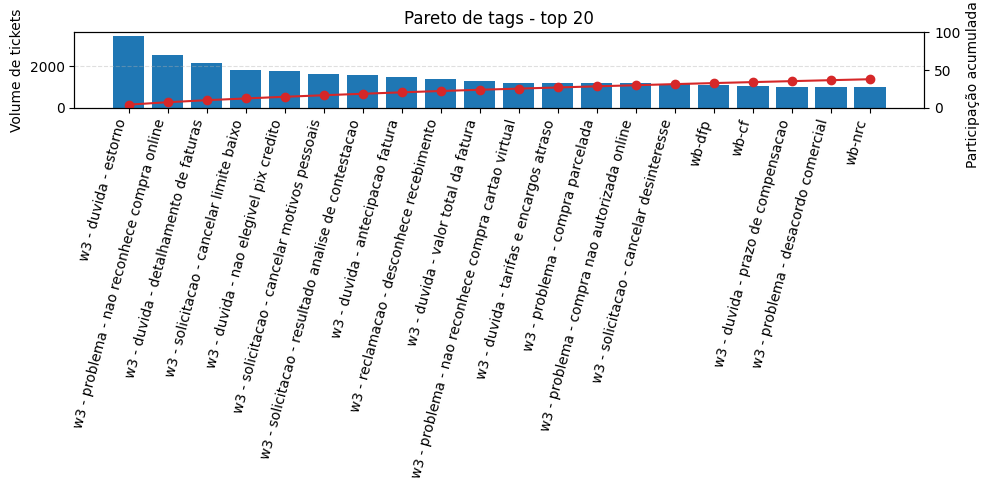

In [58]:
pareto_df = tag_share.head(20).copy()
pareto_df['cum_share_pct'] = pareto_df['cum_share'] * 100
x = range(len(pareto_df))
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(x, pareto_df['ticket_volume'], color='tab:blue')
ax1.set_ylabel('Volume de tickets')
ax1.set_xticks(list(x))
ax1.set_xticklabels(pareto_df.index, rotation=75, ha='right')
ax1.set_title('Pareto de tags - top 20')
ax2 = ax1.twinx()
ax2.plot(x, pareto_df['cum_share_pct'], color='tab:red', marker='o')
ax2.set_ylabel('Participação acumulada (%)')
ax2.set_ylim(0, 100)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [59]:
latest_month = issues_monthly.sort_values('dt_month').iloc[-1]
peak_day = issues_daily.loc[issues_daily['ticket_volume'].idxmax()]
top_issue = tag_share.iloc[0]
insights = [
    f"Último mês completo ({latest_month['dt_month']}) registrou {int(latest_month['ticket_volume']):,} chamados.",
    f"Dia de maior carga: {peak_day['dt_date']} com {int(peak_day['ticket_volume']):,} tickets.",
    f"Top tag '{top_issue.name}' responde por {top_issue['share']*100:.1f}% dos atendimentos.",
]
print('Resumo executivo de indicadores:')
for bullet in insights:
    print(f"- {bullet}")


Resumo executivo de indicadores:
- Último mês completo (2024-12) registrou 25,542 chamados.
- Dia de maior carga: 2024-12-19 com 1,524 tickets.
- Top tag 'w3 - duvida - estorno' responde por 4.3% dos atendimentos.
